# Machine Learning (Neural Network) Basics
## Part I: Introduction (Classification)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1YEIzTH91pqemhrowCdloahYtMYoaiCYP?usp=sharing)

This notebook is meant to give a brief introduction to the ideas behind machine learning and how they work.

First we will check to see that all relevant packages have been installed.

In [1]:
# install packages if they're not already
import sys
sys.path.append("figs/")
import os
print ("Using anaconda environment: {}".format(os.environ['CONDA_DEFAULT_ENV']))
!conda install --yes --prefix {sys.prefix} -c numpy scipy matplotlib pandas \
    scikit-learn scikit-learn-intelex pytorch

Using anaconda environment: pygnn
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
# we typically always use numpy, pandas and matplotlib, so import those
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# import pytorch
import torch
# determine device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA GeForce GTX 1070
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Introduction: Classification Fundamentals

One of the typical problems where we employ a machine learning algorithm is for classification of events.  Events are usually classified using a set of discriminating variables, such as momentum $\vec{p}$ or position $\vec{x}$, etc.  

What we wish to do is distinguish between events we want (signal) and events we wish to ignore (background).  Given a model of the experiment, we can generate some Monte Carlo data that will give us an idea of what to expect.  If the number of discriminating variables is small, we may be able to take the Monte Carlo and generate an estimated probability distribution of the data $P(x_1,x_2,\dots,x_n)$.  This will then allow us to determine whether an event is likely to be signal or background by evaluating something like a log-likelihood.

\begin{equation}
\xi(x^i_1,x^i_2,\dots,x^i_n) = \frac{P(x^i_1,x^i_2,\dots,x^i_n|s)}{P(x^i_1,x^i_2,\dots,x^i_n|b)}
\end{equation}

where $P(x^i_n|\theta)$ is the likelihood function for $\theta=s,b$ either being signal or background given the data point $x^i = (x^i_1,x^i_2,\dots,x^i_n)$.  

This is not always a tractible solution however if the number of variables is large or the amount of data is too sparse to accurately describe the underlying probability distribution.  Instead of trying to bin the data, we can instead use a machine learning algorithm to give us a score $\eta(x_n^i)$ from a function that we are trying to fit from the data.  That is essentially what a neural network or any machine learning algorithm in general is doing.  

#### Gaussian blobs example
---------------------------
Neural networks have an advantage in that they are non-linear and do practically all of the work in training themselves with very little input from the user.  You can gain an intuition for what a neural network is doing by thinking in terms of regression.  Imagine that you had some data distributed according to the following figure:


/tmp/ipykernel_77240/2544521308.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  x_1, y_1 = np.random.multivariate_normal(mean_1, cov_1, 5000).T
/tmp/ipykernel_77240/2544521308.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  x_2, y_2 = np.random.multivariate_normal(mean_2, cov_2, 5000).T


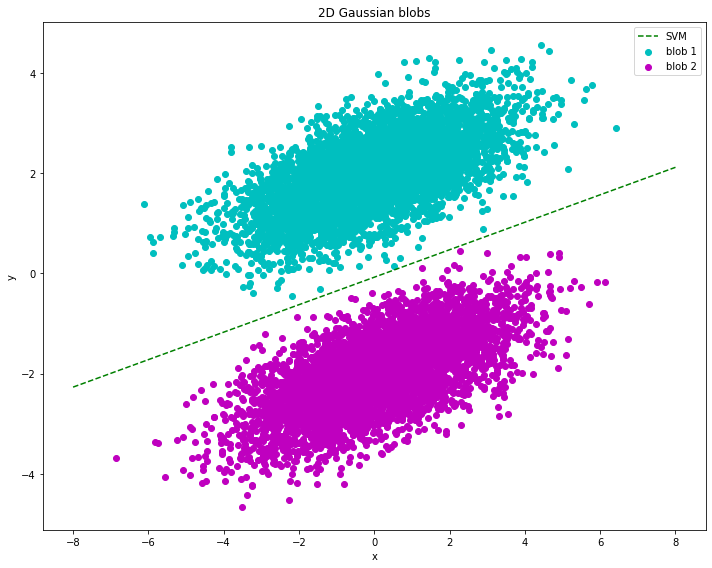

In [4]:
""" 
Generate two 2D gaussian blobs with some separation between them.
Then, use a support vector machine to get a descriminating line.
"""
from ml_helpers import get_best_svm_fit

# We'll make some 2D gaussian distributions using a covariance matrix
mean_1, mean_2 = [0,2], [0,-2]
cov_1, cov_2 = [[1,0],[3,1]], [[1,0],[3,1]]
x_1, y_1 = np.random.multivariate_normal(mean_1, cov_1, 5000).T
x_2, y_2 = np.random.multivariate_normal(mean_2, cov_2, 5000).T

xx, yy = get_best_svm_fit(x_1,y_1,x_2,y_2)
# The previous section used the scikit-learn support vector machine to generate the 
# best discriminating hyperplane

fig, axs = plt.subplots(figsize=(10,8))
axs.scatter(x_1,y_1,color='c',label='blob 1')
axs.scatter(x_2,y_2,color='m',label='blob 2')
axs.plot(xx,yy,color='g',linestyle='--',label='SVM')
axs.set_xlabel("x")
axs.set_ylabel("y")
axs.set_title("2D Gaussian blobs")
plt.legend()
plt.tight_layout()
plt.show()

The [scikit-learn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets) package provides some useful tools for generating simple test datasets, like the blobs above.  

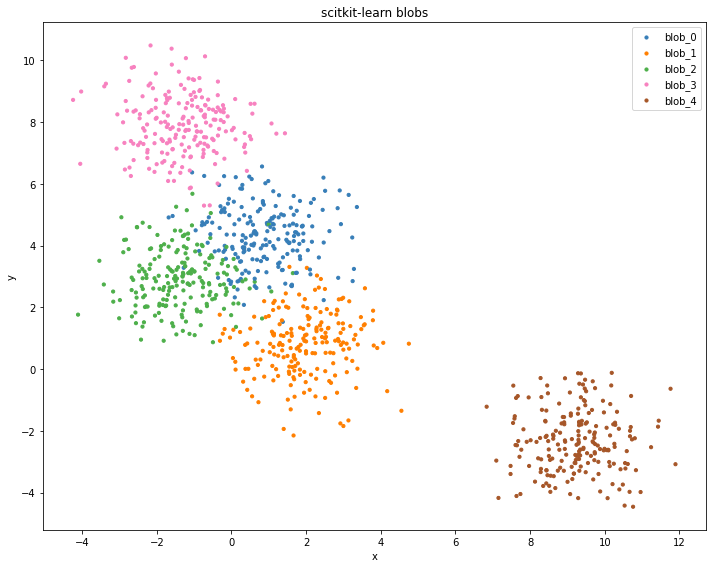

In [11]:
"""
Generate blobs from the scikit-learn package.
"""
# sklearn datasets has several generators, like make_blobs
from sklearn.datasets import make_blobs
from ml_helpers import plot_2d_classification
# generate samples and labels
x, y = make_blobs(
    n_samples=1000,     # number of samples to generate
    centers=5,          # number of blobs (classes)
    n_features=2,       # dimension of the dataset
    random_state=0      # seed for the random generation
)

# plot examples
plot_2d_classification(x,y,title="scitkit-learn blobs",names=[f'blob_{i}' for i in range(5)])

#### Non-linear separation (Two moons example)
----------------------
As you can see, generating a best discriminating hyperplane is easy in this example, and the data is actually decently separable. This is not always the case and a linear separation technique will not fair well in an example such as the following:

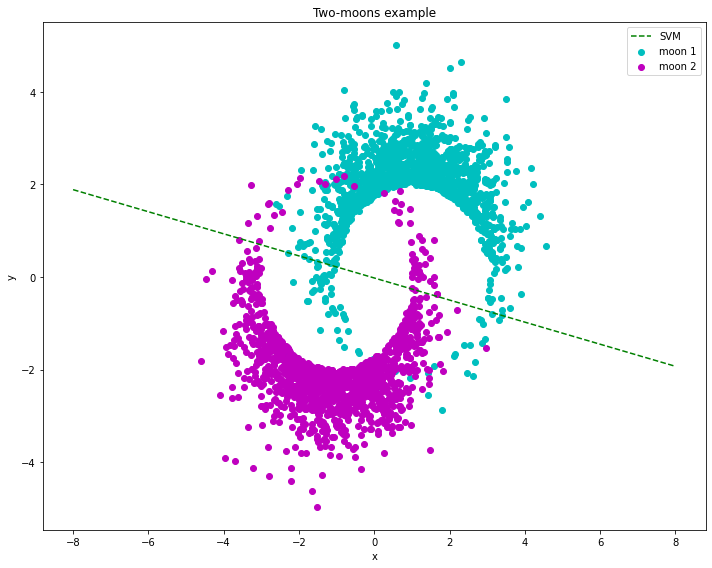

In [12]:
""" 
Generate two 2D gaussian blobs with some separation between them.
Then, cut out centers to make a two-moons dataset.
Then, use a support vector machine to get a descriminating line.
"""
from ml_helpers import generate_two_moons_example, get_best_svm_fit, plot_two_moons
# We'll make some more 2D distributions which are not nicely overlapped.
mean_1, mean_2 = [1,1], [-1,-1]
cov_1, cov_2 = [[1,0],[0,1]], [[1,0],[0,1]]
x_1, y_1 = np.random.multivariate_normal(mean_1, cov_1, 5000).T
x_2, y_2 = np.random.multivariate_normal(mean_2, cov_2, 5000).T

# Now to plot them with a best discriminating line between them
x_1, y_1, x_2, y_2 = generate_two_moons_example(x_1,y_1,x_2,y_2)

xx, yy = get_best_svm_fit(x_1,y_1,x_2,y_2)
# The previous section used the scikit-learn support vector machine to generate the 
# best discriminating hyperplane

# plot the results
plot_two_moons(x_1,y_1,x_2,y_2,xx,yy)

Obviously the discriminating line from the support vector machine is not the best separation possible, we can do much better. As we will see, a neural network is a much more flexible structure and can stretch and skew the space such that when we construct a discriminating hyperplane it will be a separation that looks more like the figure from before with the Gaussian blobs.

We can also generate moons from the [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons) package.

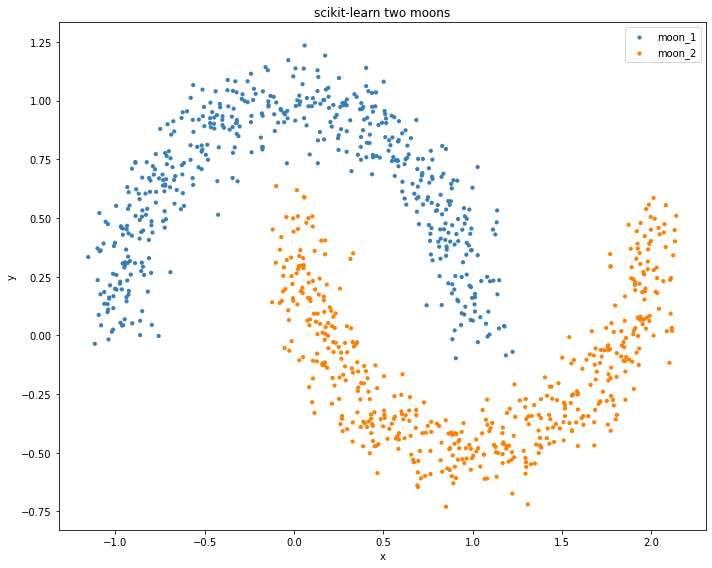

In [13]:
"""
Generate two-moons from the scikit-learn package.
"""
from sklearn.datasets import make_moons
from ml_helpers import plot_2d_classification
# generate samples and labels
x, y = make_moons(
    n_samples=1000,     # number of samples to generate
    shuffle=False,      # whether to shuffle the samples
    noise=.1,           # standard deviation of Gaussian noise added
    random_state=0      # seed for the random generation
)

# plot examples
plot_2d_classification(x,y,title='scikit-learn two moons',names=['moon_1','moon_2'])

#### Enclosed blobs
-------------------
Before I get into the theory of neural networks, there's another example which any linear regression will not handle well. This is when regions of signal and background are surrounded by each other, two of the simplest cases are the following:

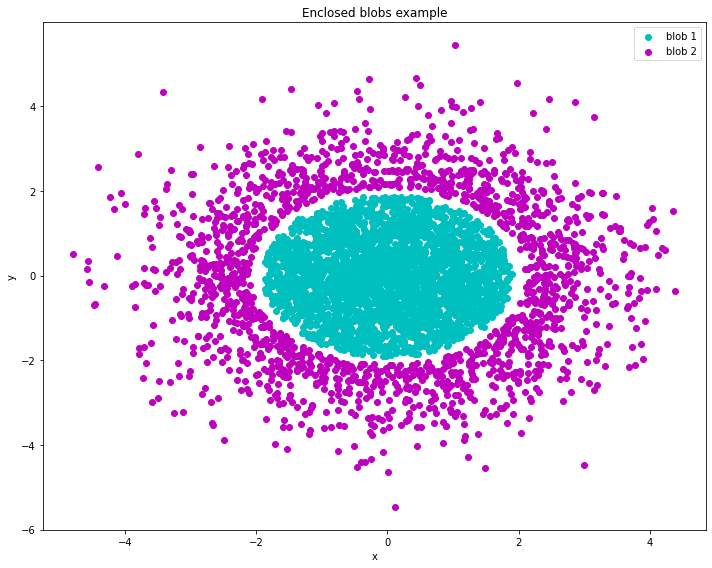

In [8]:
""" 
Generate two 2D enclosed gaussian blobs.
"""
from ml_helpers import generate_enclosed_blobs_example, plot_enclosed_blobs
# Here we have regions of signal and background that are surrounded by each other
mean_1, mean_2 = [0,0], [0,0]
cov_1, cov_2 = [[2,0],[0,2]], [[2,0],[0,2]]
x_1, y_1 = np.random.multivariate_normal(mean_1, cov_1, 5000).T
x_2, y_2 = np.random.multivariate_normal(mean_2, cov_2, 5000).T

# generate enclosed blobs
x_1, y_1, x_2, y_2 = generate_enclosed_blobs_example(x_1,y_1,x_2,y_2)

# plot the results
plot_enclosed_blobs(x_1,y_1,x_2,y_2)

We can generate a similar example from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html#sklearn.datasets.make_circles), which consists of two overlapping circles.

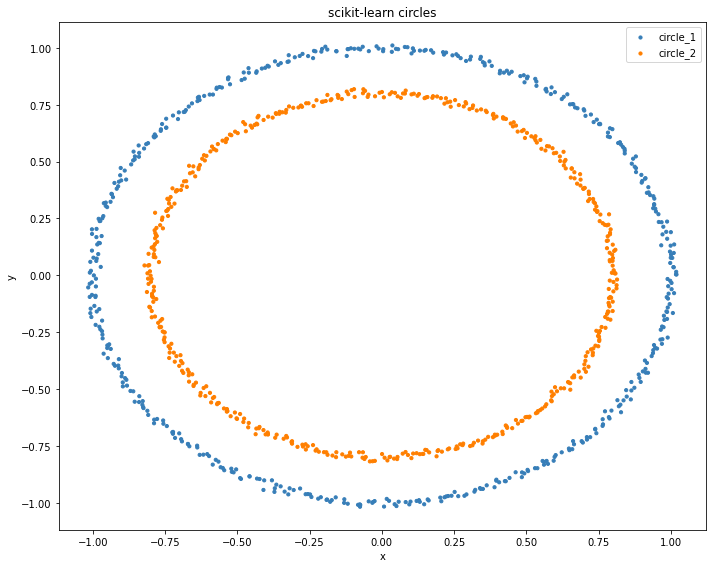

In [15]:
"""
Generate circles from the scikit-learn package.
"""
from sklearn.datasets import make_circles
from ml_helpers import plot_2d_classification
# generate samples and labels
x, y = make_circles(
    n_samples=1000,     # number of samples to generate
    shuffle=False,      # whether to shuffle the samples
    noise=.01,          # standard deviation of Gaussian noise added
    random_state=0,     # seed for the random generation
    factor=.8           # scale factor between inner and outer circles
)

# plot examples
plot_2d_classification(x,y,title='scikit-learn circles',names=['circle_1','circle_2'])

#### Several enclosed blobs
---------------------------
Clearly the two regions are completely separate, but no linear regression will be able to discriminate between the two in an optimal way. The same is true for when regions of the space have sub groupings, which we will explore when we try to analyze these situations using a neural network:

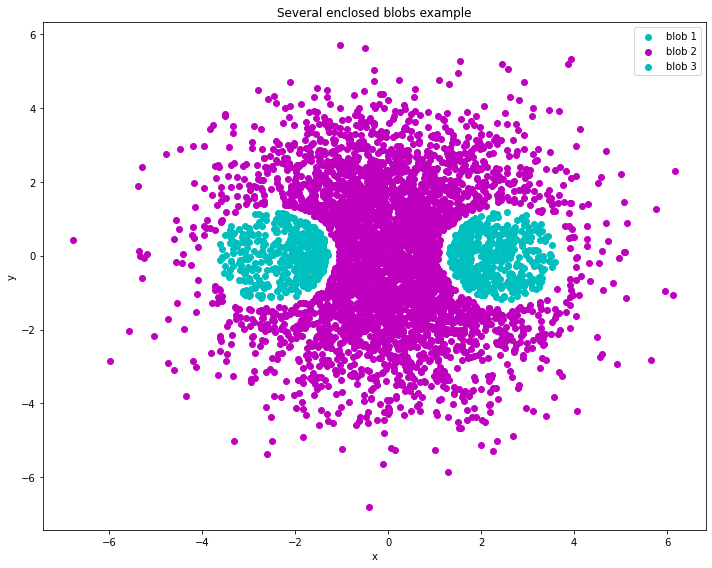

In [9]:
""" 
Generate several 2D enclosed gaussian blobs.
"""
from ml_helpers import generate_two_enclosed_blobs_example, plot_two_enclosed_blobs
# Here we have two regions of signal surrounded by background.
mean_1, mean_2 = [0,0], [0,0]
cov_1, cov_2 = [[3,0],[0,3]], [[3,0],[0,3]]
x_1, y_1 = np.random.multivariate_normal(mean_1, cov_1, 5000).T
x_2, y_2 = np.random.multivariate_normal(mean_2, cov_2, 5000).T

# Now to generate the blobs
x_1, y_1, x_2, y_2, x_3, y_3 = generate_two_enclosed_blobs_example(x_1,y_1,x_2,y_2)

# Plot the results
plot_two_enclosed_blobs(x_1,y_1,x_2,y_2,x_3,y_3)

#### A more realistic example
-----------------------------
The two previous results are a bit naive, in that data is never truly separated in such a fashion.  A more typical result is something that looks like the following:

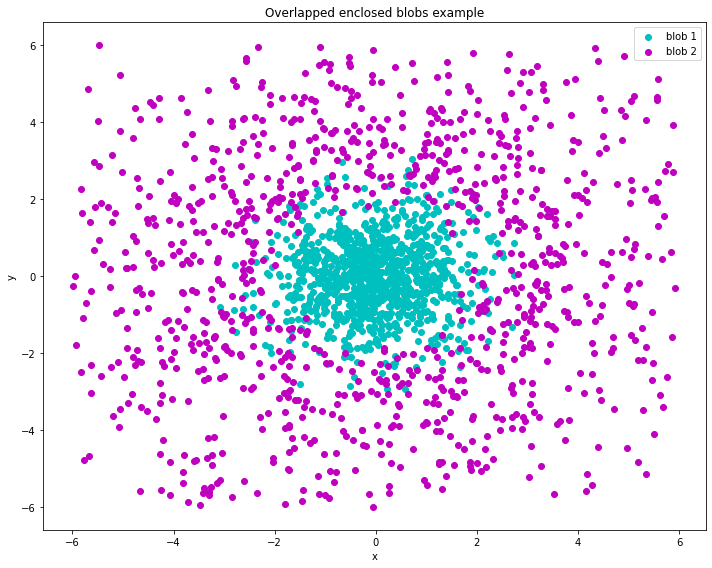

In [10]:
""" 
Generate two 2D enclosed gaussian blobs with some overlap.
"""
from ml_helpers import generate_overlapped_enclosed_blob_example, plot_overlapped_enclosed_blob
# Here we have regions of signal and background that are surrounded by each other
x_1, y_1, x_2, y_2 = generate_overlapped_enclosed_blob_example(num_samples=1000)

# Plot the result
plot_overlapped_enclosed_blob(x_1,y_1,x_2,y_2)